In [1]:
# Calculate level sets of the invariant version of the eikonal depth
# for a mixture of two Gaussian probability distributions

import numpy as np
import scipy as sp
from numpy import linalg as la
import math
from scipy.linalg import sqrtm

import os

import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=16)   
plt.rc('ytick', labelsize=16) 
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

N=128*2
ratio=4
#n=(N+1)**2
n=(N+1+2*ratio)**2

thickness=ratio/N

# Generate points when using the grid
x=np.linspace(-4-thickness,4+thickness,N+1+2*ratio)
y=np.linspace(-4-thickness,4+thickness,N+1+2*ratio)
points=np.empty((0,2))
for i in x:
    for j in y:
        points=np.append(points,[[i,j]],axis=0)


#Find points that are in the boundary region
in_boundary = 1*(points[:,0]<=-4)+1*(points[:,0]>=4)+1*(points[:,1]<=-4)+1*(points[:,1]>=4)
in_boundary = 1*(in_boundary>0)

# Needed when using the grid
nEffective=(N+1)**2

X=points[:,0]
Y=points[:,1]
F=np.zeros((n,1))
f=np.zeros((n,1))
f1=np.zeros((n,1))
f2=np.zeros((n,1))

mu1x=0.0
mu1y=0.0
s1x=0.3
s1y=0.1
rho=0.0

mu2x=0.3
mu2y=0.5
s2x=0.2
s2y=0.1
rho=0.0

cov1 = np.array([[s1x**2, rho*s1x*s1y], [rho*s1x*s1y, s1y**2]])
cov1Inv=la.inv(cov1)
cov1Det=la.det(cov1)
Mu1=np.array([[mu1x,mu1y],])

cov2 = np.array([[s2x**2, rho*s2x*s2y], [rho*s2x*s2y, s2y**2]])
cov2Inv=la.inv(cov2)
cov2Det=la.det(cov2)
Mu2=np.array([[mu2x,mu2y],])

# The covariance for the sum is
covsum=np.array([[s1x**2+s2x**2+0.5*mu2x**2, 0.5*mu2x*mu2y],[0.5*mu2x*mu2y, s1y**2+s2y**2+0.5*mu2y**2]])
sqrtR=sqrtm(covsum)
invsqrtR=la.inv(sqrtR)

for i in range(n):
    X=sqrtR.dot(np.array([points[i,:],]).T)
    X=X.T
    f1[i]=np.exp(-0.5*(X-Mu1)@cov1Inv@np.transpose(X-Mu1))/(np.pi*2*np.sqrt(cov1Det))
    f2[i]=np.exp(-0.5*(X-Mu2)@cov2Inv@np.transpose(X-Mu2))/(np.pi*2*np.sqrt(cov2Det))
    f[i]=0.5*(f1[i]+f2[i])
    f[i]=la.det(sqrtR)*np.sqrt(f[i])
    
for i in range(n):
    F[i]=1/f[i]
    
F[np.nonzero(in_boundary)]=0

In [2]:
from scipy.spatial.distance import pdist,squareform

from sklearn.neighbors import radius_neighbors_graph

# Cut-off for the neighborhood graph
radius=8*ratio/N
sigma=0.2

sparse_graph = radius_neighbors_graph(points, radius, mode='connectivity',include_self=True)

dist_mat = radius_neighbors_graph(points, radius, mode='distance',include_self=True)
wght_mat=dist_mat
wght_mat.data=np.exp(-dist_mat.data**2/(2*sigma**2*radius**2))/(np.pi*nEffective*radius**4*sigma**4)

print('Minimum number of neighbors')
print(np.min(np.sum(1*(sparse_graph>0),axis=1)))
print('Maximum number of neighbors')
print(np.max(np.sum(1*(sparse_graph>0),axis=1)))

Minimum number of neighbors
17
Maximum number of neighbors
49


In [3]:
values = 100*np.ones(n)

#Initialize the solved set/list/values
solved_list = np.nonzero(in_boundary)[0]
solved_set = set(solved_list)
values[solved_list] = 0.

max_solved = 0.

from scipy.sparse import find

#Initialize the considered set
considered_set = set()
for i in solved_list:
    neighbors = set(find(sparse_graph[i,:])[1])
    considered_set = considered_set.union(neighbors.difference(solved_set))
update_set = considered_set

#Create a list so that neighbor_set_list[i] = {Neighbors of i}
neighbor_set_list = []
for i in range(n):
    neighbor_set_list.append(set(find(sparse_graph[i,:])[1]))
k = len(solved_set)


while considered_set:
    
    #This is just a progress indicator
    if k%100 == 0:
        print("{:.2f} %".format(k/n*100),end='\r')
    k += 1
    
    #Letting num_iter be small after some burn-in period.
    if k > 100:
        num_iter = 1
    #print(len(considered_set))
    new_max_solved = 1000.
    new_max_solved_index = -1

    for i in update_set:
        neighbors = neighbor_set_list[i]
        solved_neighbors = list(neighbors.intersection(solved_set))  
        neighbor_weights = wght_mat[i,solved_neighbors].toarray()[0]
        neighbor_values = values[solved_neighbors]
            
            
        values[i] = (neighbor_values.dot(neighbor_weights) + np.sqrt(neighbor_values.dot(neighbor_weights)**2 - np.sum(neighbor_weights)*((neighbor_values**2).dot(neighbor_weights) - 1/F[i]**2)))/np.sum(neighbor_weights)
    
    #Here we use update set to track places in the considered set where values need to be updates (i.e. there is a new solved neighbor)
    l = list(considered_set)
    min_index = l[np.argmin(values[l])]
    solved_set.add(min_index)
    solved_list = list(solved_set)
    considered_set.remove(min_index)
    update_set = neighbor_set_list[min_index].difference(solved_set)
    considered_set = considered_set.union(update_set)


print("Calculations complete")

Calculations complete


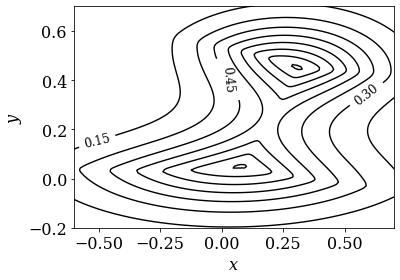

In [4]:
points2=sqrtR.dot(points.T).T
fig1, ax = plt.subplots()
CS=plt.tricontour(points2[:,0],points2[:,1], values,levels=8, linewidths=1.4,colors='black')
fmt = '%.2f'
ax.clabel(CS,CS.levels[1:4], inline_spacing=-7, fontsize=12, fmt=fmt)
plt.axis('square')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.xlim([-0.6, 0.7])
plt.ylim([-0.2, 0.7])
plt.tight_layout()
plt.savefig('depthcontours_bimodalGaussianInvariant.pdf', dpi=300)